# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Gradient Boosting</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Gradient Descent, Decision Trees, and Newton</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

Inspired by the amazing [Blog post](http://nicolas-hug.com/blog/gradient_boosting_descent) from Nicolas Hug

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = 'is_bad'

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Gradient Boosting model</span>

A custom implementation of of gradient descent with a decision tree.

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from scipy.special import expit as sigmoid


class BinaryCrossEntropy:
    @staticmethod
    def compute_gradients(y_true, y_pred):
        preds = sigmoid(y_pred)
        return preds - y_true

    @staticmethod
    def compute_hessians(y_true, y_pred):
        preds = sigmoid(y_pred)
        return preds * (1 - preds)

    @staticmethod
    def raw_predictions_to_proba(raw_predictions):
        return sigmoid(raw_predictions)


class BaseGradientBoosting(BaseEstimator):
    def __init__(
        self,
        n_iter=100,
        learning_rate=0.1,
        min_hessian=1e-5,
        loss=BinaryCrossEntropy(),
        base_learner="tree",
    ):
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.min_hessian = min_hessian
        self.predictors = []
        self.loss_dict = []
        self.base_learner_type = base_learner
        self.method = 'GD'

    def fit(self, X, y):
        y_pred_train = np.zeros(X.shape[0], dtype=np.float64)

        for _ in range(self.n_iter):

            if self.method == 'GD':
                negative_gradient = -self.loss.compute_gradients(y, y_pred_train)
            elif self.method == 'Newton':
                negative_gradient = -self.loss.compute_gradients(y, y_pred_train)
                hessian = self.loss.compute_hessians(y, y_pred_train)
                hessian_with_offset = np.clip(
                    hessian, a_min=self.min_hessian, a_max=None
                )
                negative_gradient /= hessian_with_offset

            if self.base_learner_type == "tree":
                new_predictor = DecisionTreeRegressor(max_depth=3)
            elif self.base_learner_type == "linear":
                new_predictor = LinearRegression()

            new_predictor.fit(X, y=self.learning_rate * negative_gradient)
            y_pred_train += new_predictor.predict(X)

            log_loss_score = log_loss(
                y, self.loss.raw_predictions_to_proba(y_pred_train)
            )
            self.predictors.append(new_predictor)
            self.loss_dict.append(log_loss_score)

    def predict(self, X):
        return np.sum([predictor.predict(X) for predictor in self.predictors], axis=0)


class GradientBoostingClassifier(BaseGradientBoosting, ClassifierMixin):
    def __init__(
        self,
        n_iter=100,
        learning_rate=0.1,
        min_hessian=1e-5,
        loss=BinaryCrossEntropy(),
        base_learner="tree",
        method='GD'
    ):
        super().__init__(n_iter, learning_rate, min_hessian, loss, base_learner)

    def predict_proba(self, X):
        raw_predictions = super().predict(X)
        prob_positive_class = self.loss.raw_predictions_to_proba(raw_predictions)
        return np.column_stack((1 - prob_positive_class, prob_positive_class))

    def predict(self, X):
        proba_positive_class = self.predict_proba(X)[:, 1]
        return proba_positive_class > 0.5

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Gradient Boosting with Decision Trees</span>

An implementation of of gradient boosting with a decision tree.

Gini train: 90.83%
Gini test: 88.79%


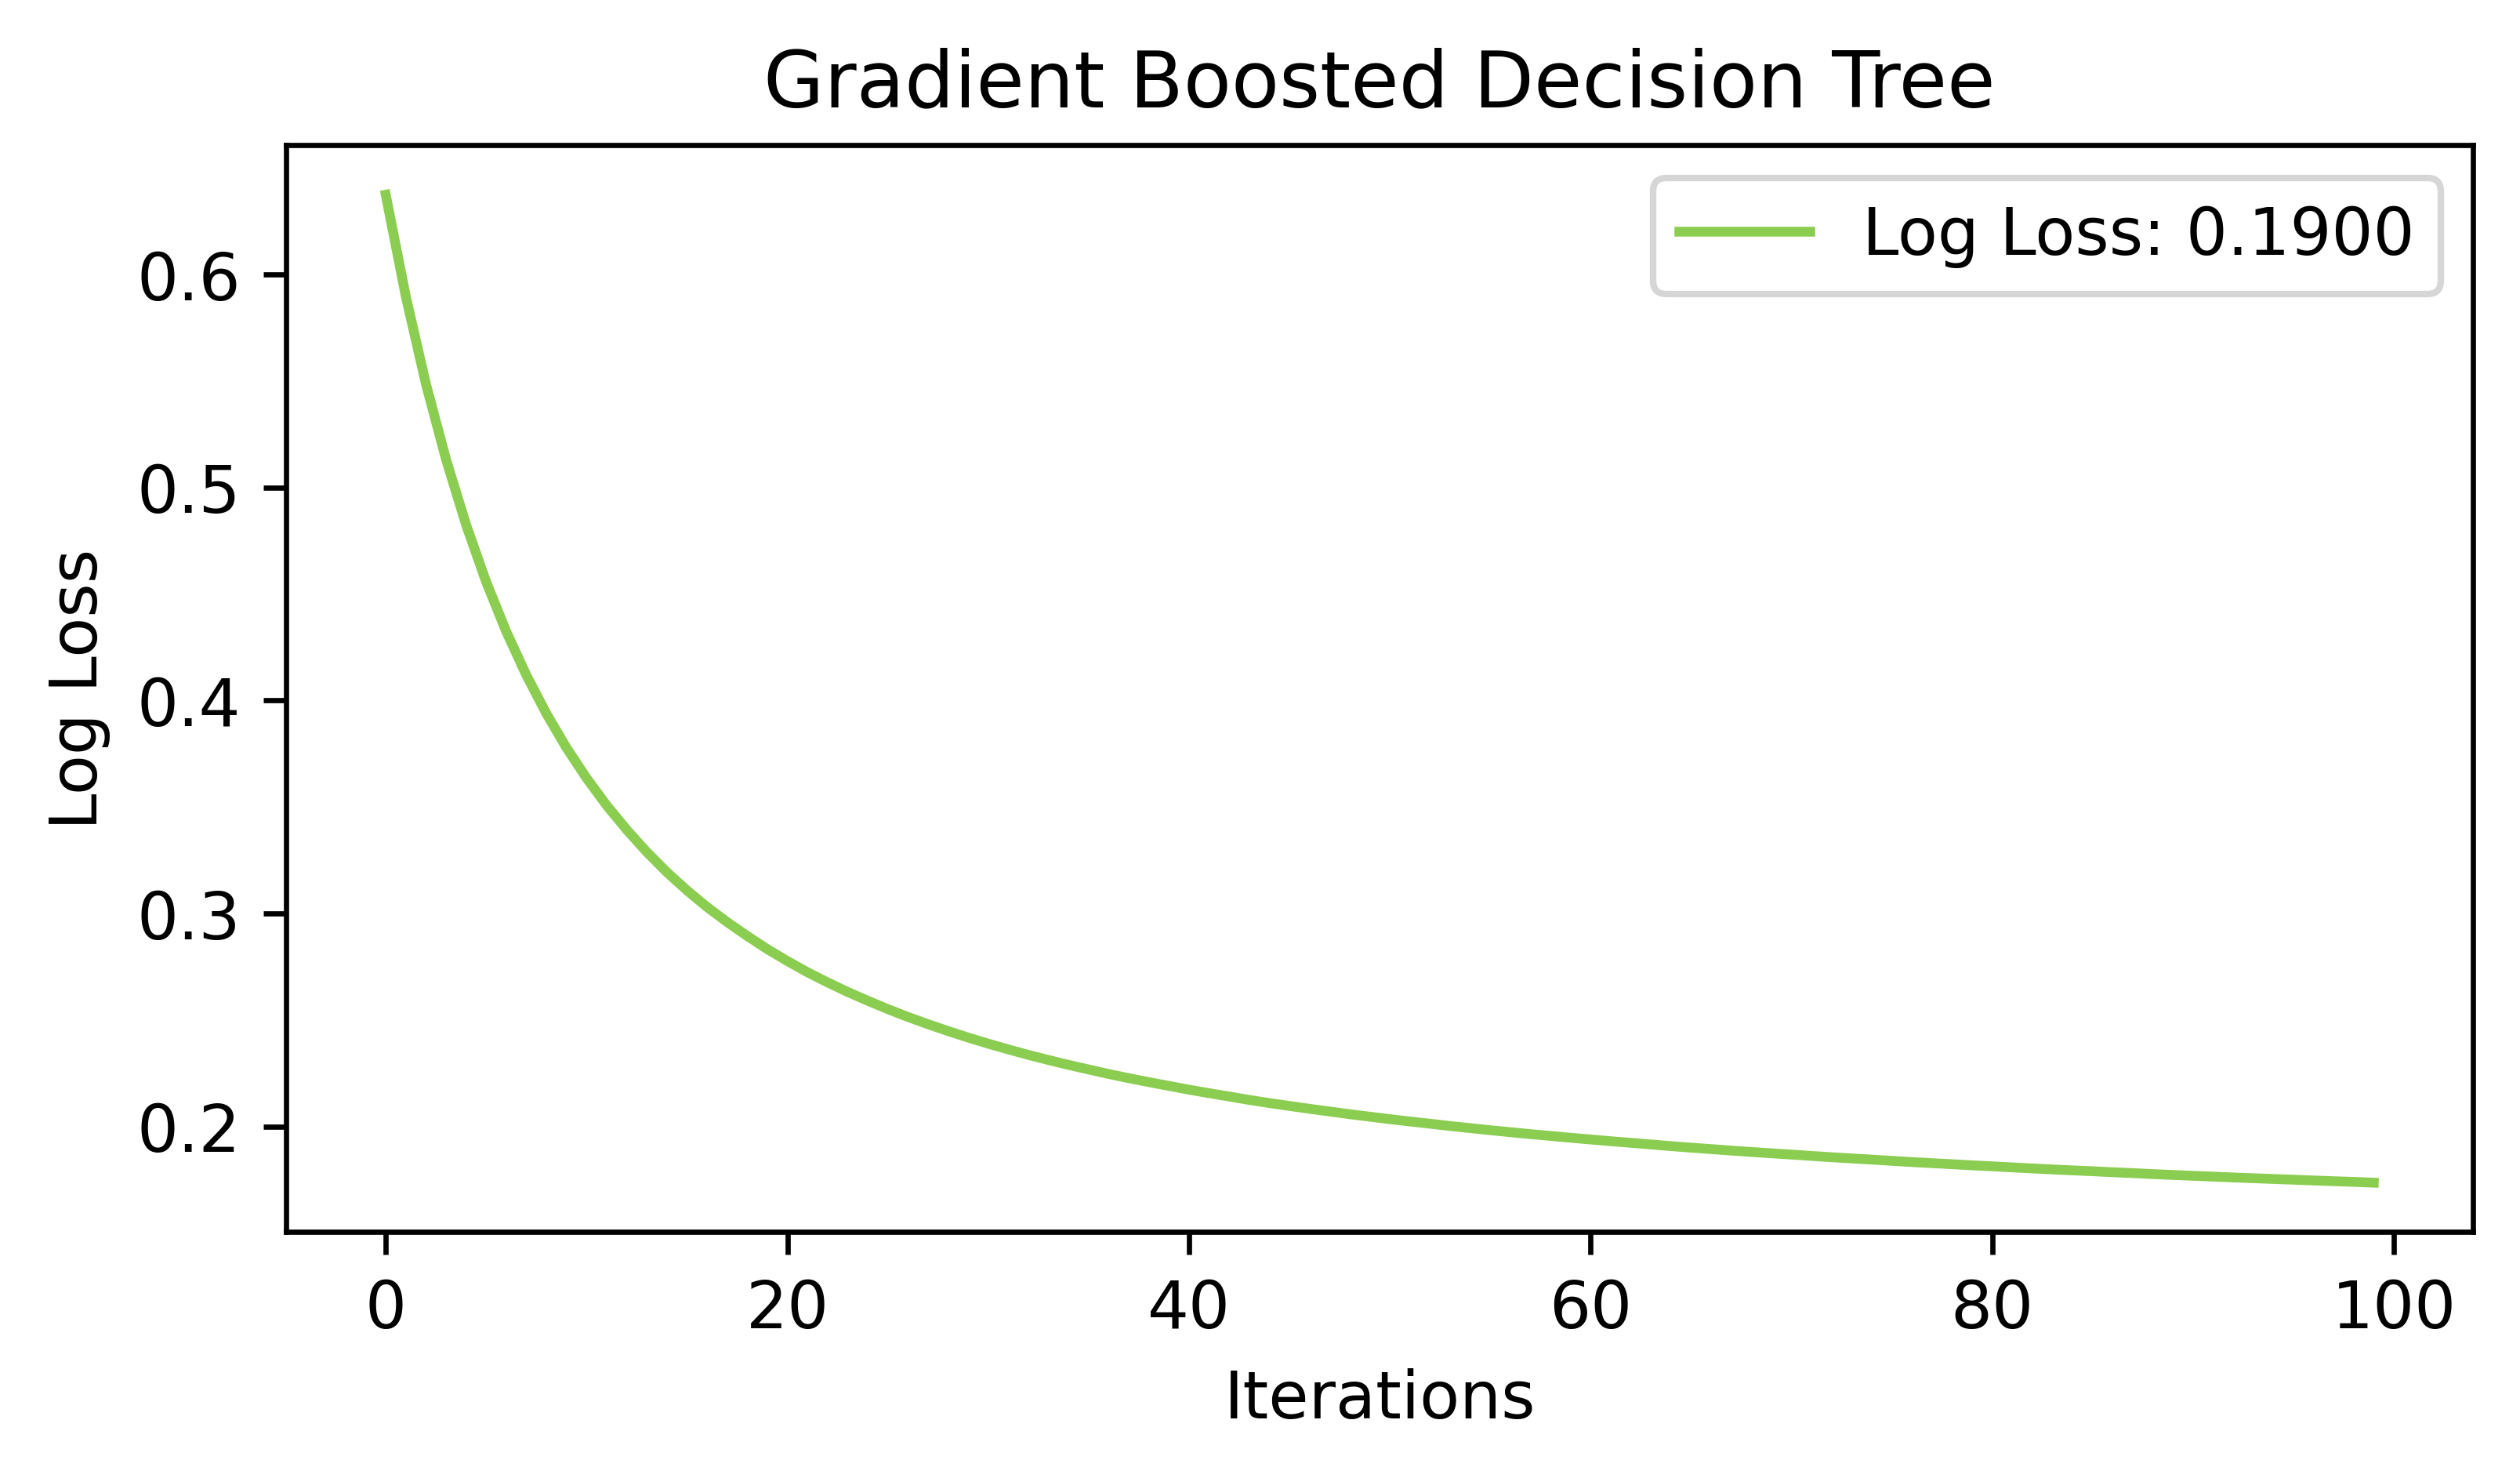

In [3]:
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

gbdt = GradientBoostingClassifier(n_iter=100, learning_rate=.3, base_learner='tree')
gbdt.fit(X.loc[ix_train], y.loc[ix_train])

gini_train = roc_auc_score(y.loc[ix_train], gbdt.predict_proba(X.loc[ix_train])[:, 1]) * 2 - 1
gini_test = roc_auc_score(y.loc[ix_test], gbdt.predict_proba(X.loc[ix_test])[:, 1]) * 2 - 1

print(f"Gini train: {gini_train:.2%}")
print(f"Gini test: {gini_test:.2%}")

log_loss_score = log_loss(y.loc[ix_test], gbdt.predict_proba(X.loc[ix_test])[:, 1])

plt.figure(figsize=(6, 3), dpi=600)
plt.title("Gradient Boosted Decision Tree")
plt.plot(gbdt.loss_dict, color='#8bcd50', label=f"Log Loss: {log_loss_score:.4f}")
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Gradient Boosting with a Linear Model</span>

A custom implementation of of gradient descent with a linear regression.

Gini train: 80.26%
Gini test: 80.30%


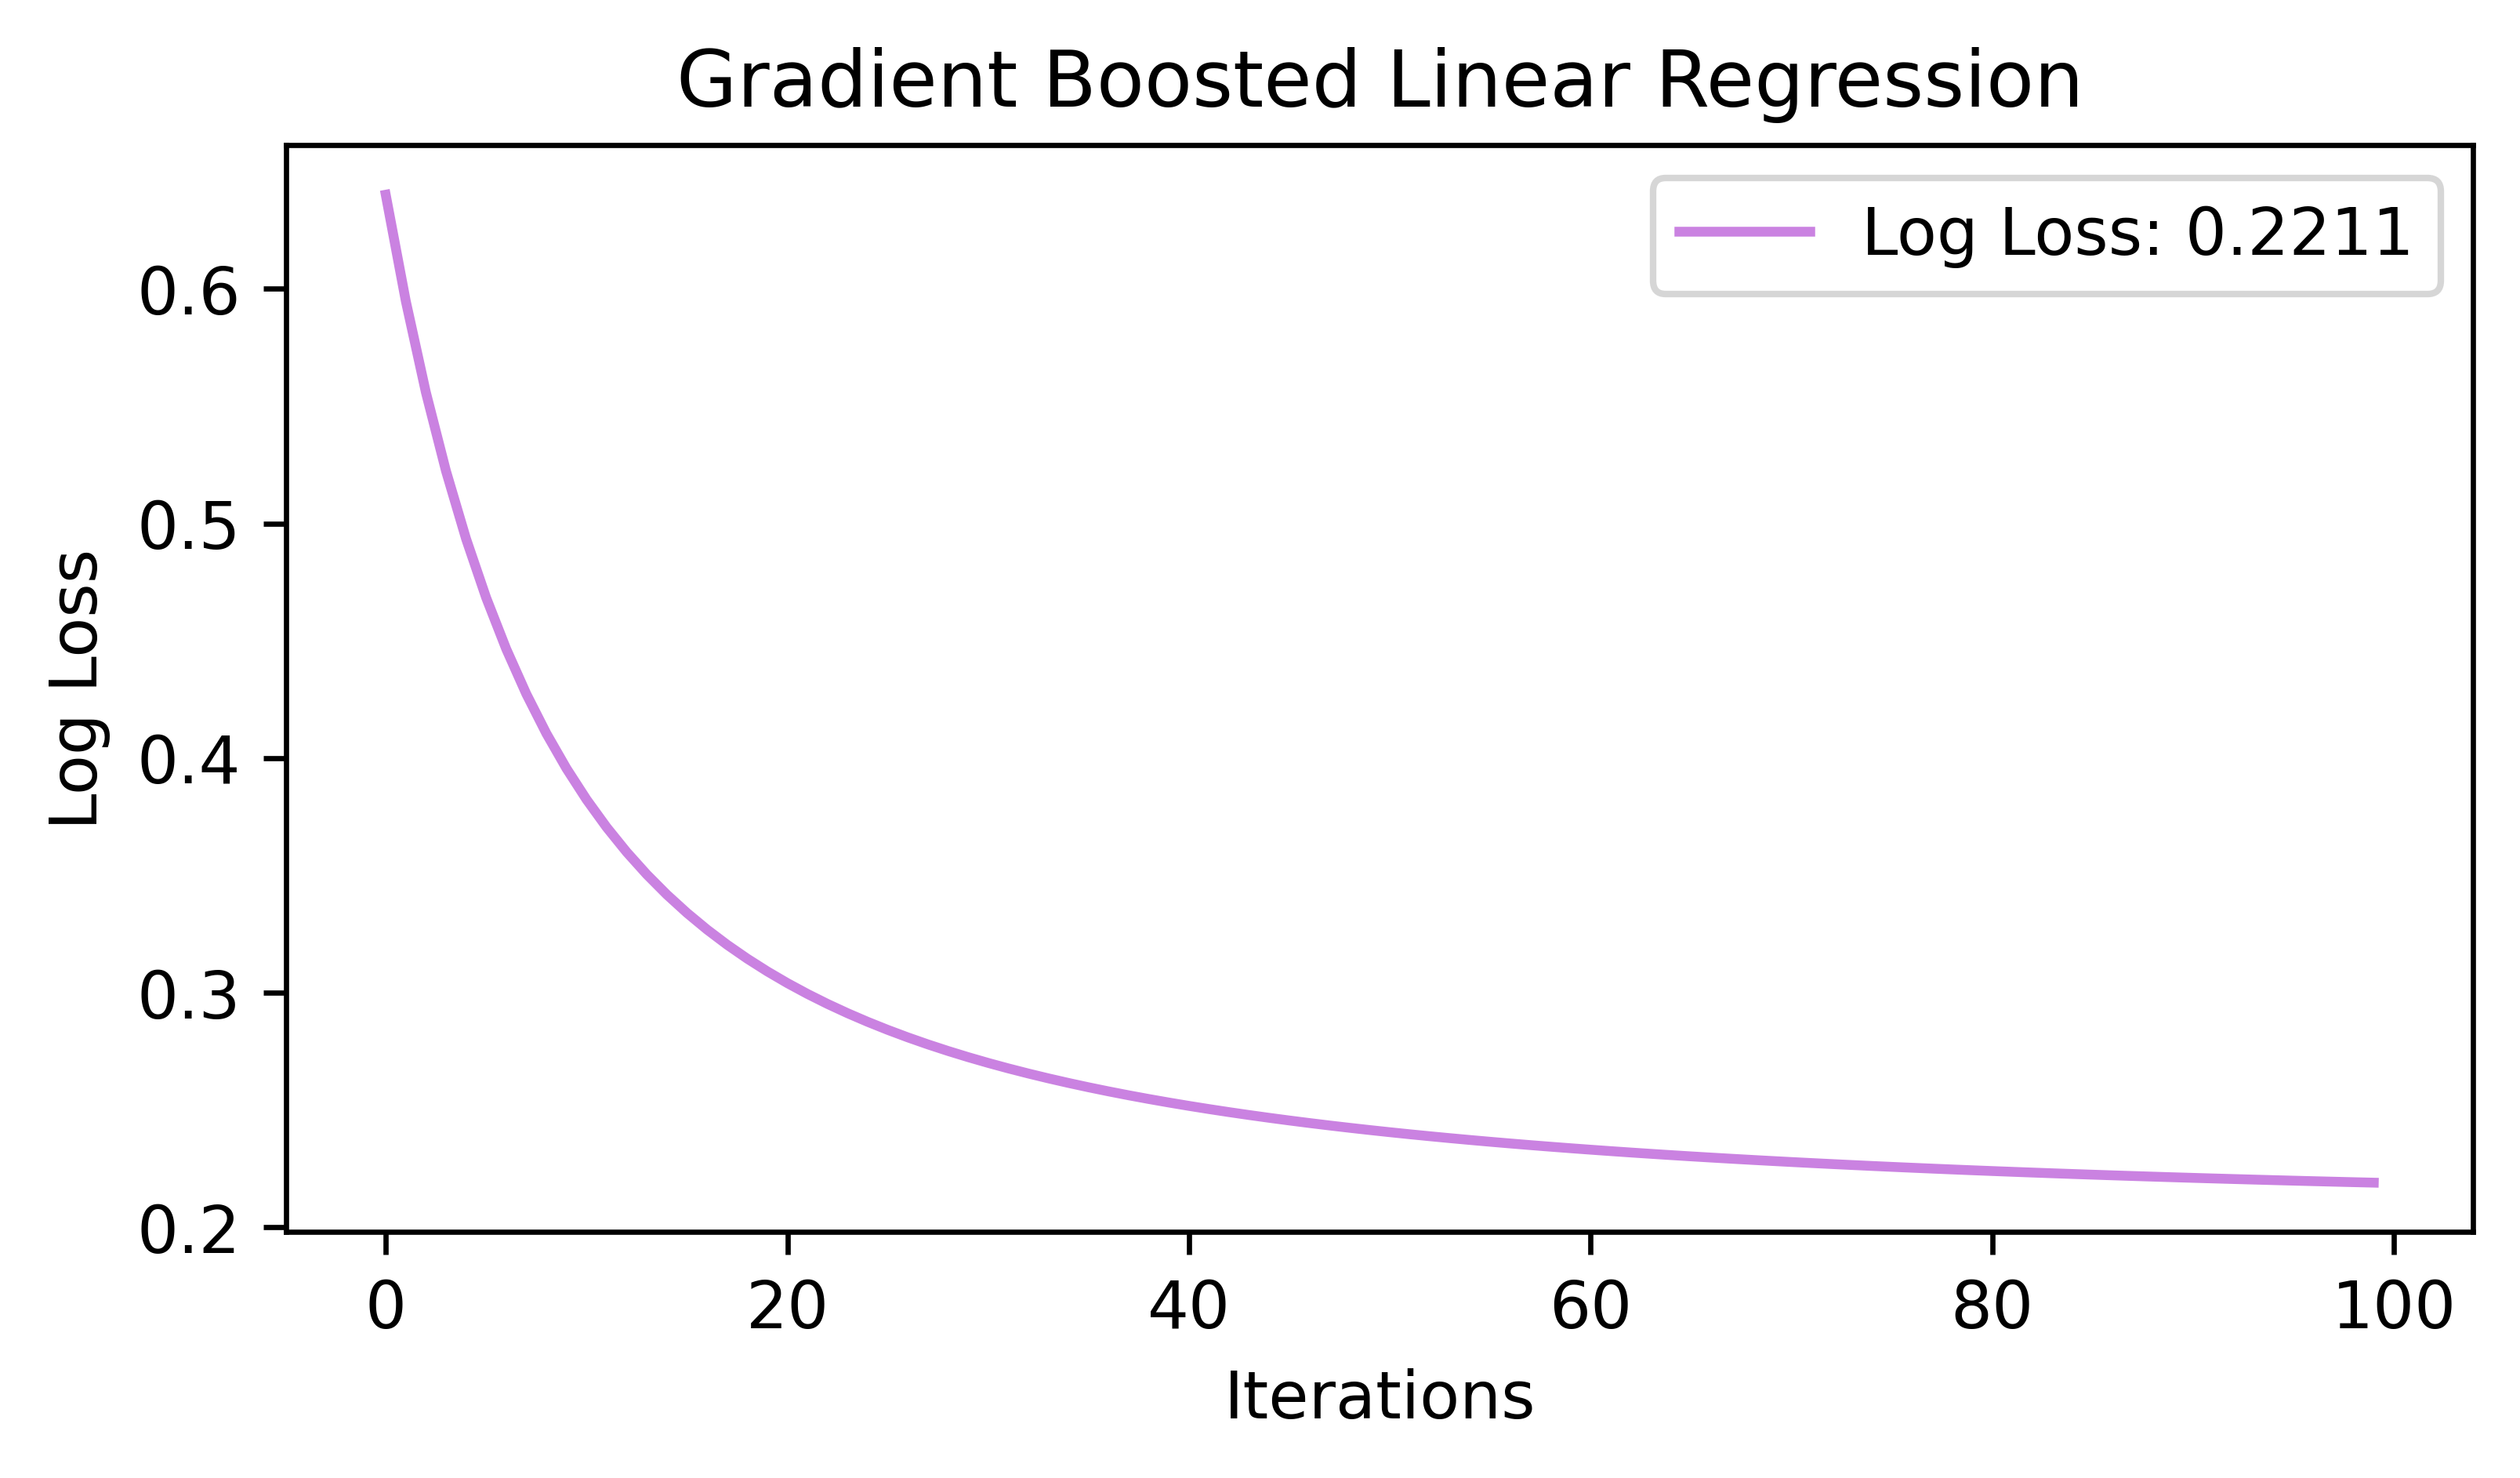

In [4]:
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

gb_linear = GradientBoostingClassifier(n_iter=100, learning_rate=.3, base_learner='linear')
gb_linear.fit(X.loc[ix_train], y.loc[ix_train])

gini_train = roc_auc_score(y.loc[ix_train], gb_linear.predict_proba(X.loc[ix_train])[:, 1]) * 2 - 1
gini_test = roc_auc_score(y.loc[ix_test], gb_linear.predict_proba(X.loc[ix_test])[:, 1]) * 2 - 1

print(f"Gini train: {gini_train:.2%}")
print(f"Gini test: {gini_test:.2%}")

log_loss_score = log_loss(y.loc[ix_test], gb_linear.predict_proba(X.loc[ix_test])[:, 1])

plt.figure(figsize=(6, 3), dpi=600)
plt.title("Gradient Boosted Linear Regression")
plt.plot(gb_linear.loss_dict, color='#ca82e1', label=f"Log Loss: {log_loss_score:.4f}")
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Newton Boosting</span>

This method uses the Newton-Raphson method to minimize the loss function.

Gini train: 91.19%
Gini test: 88.92%
0.16482895543300233


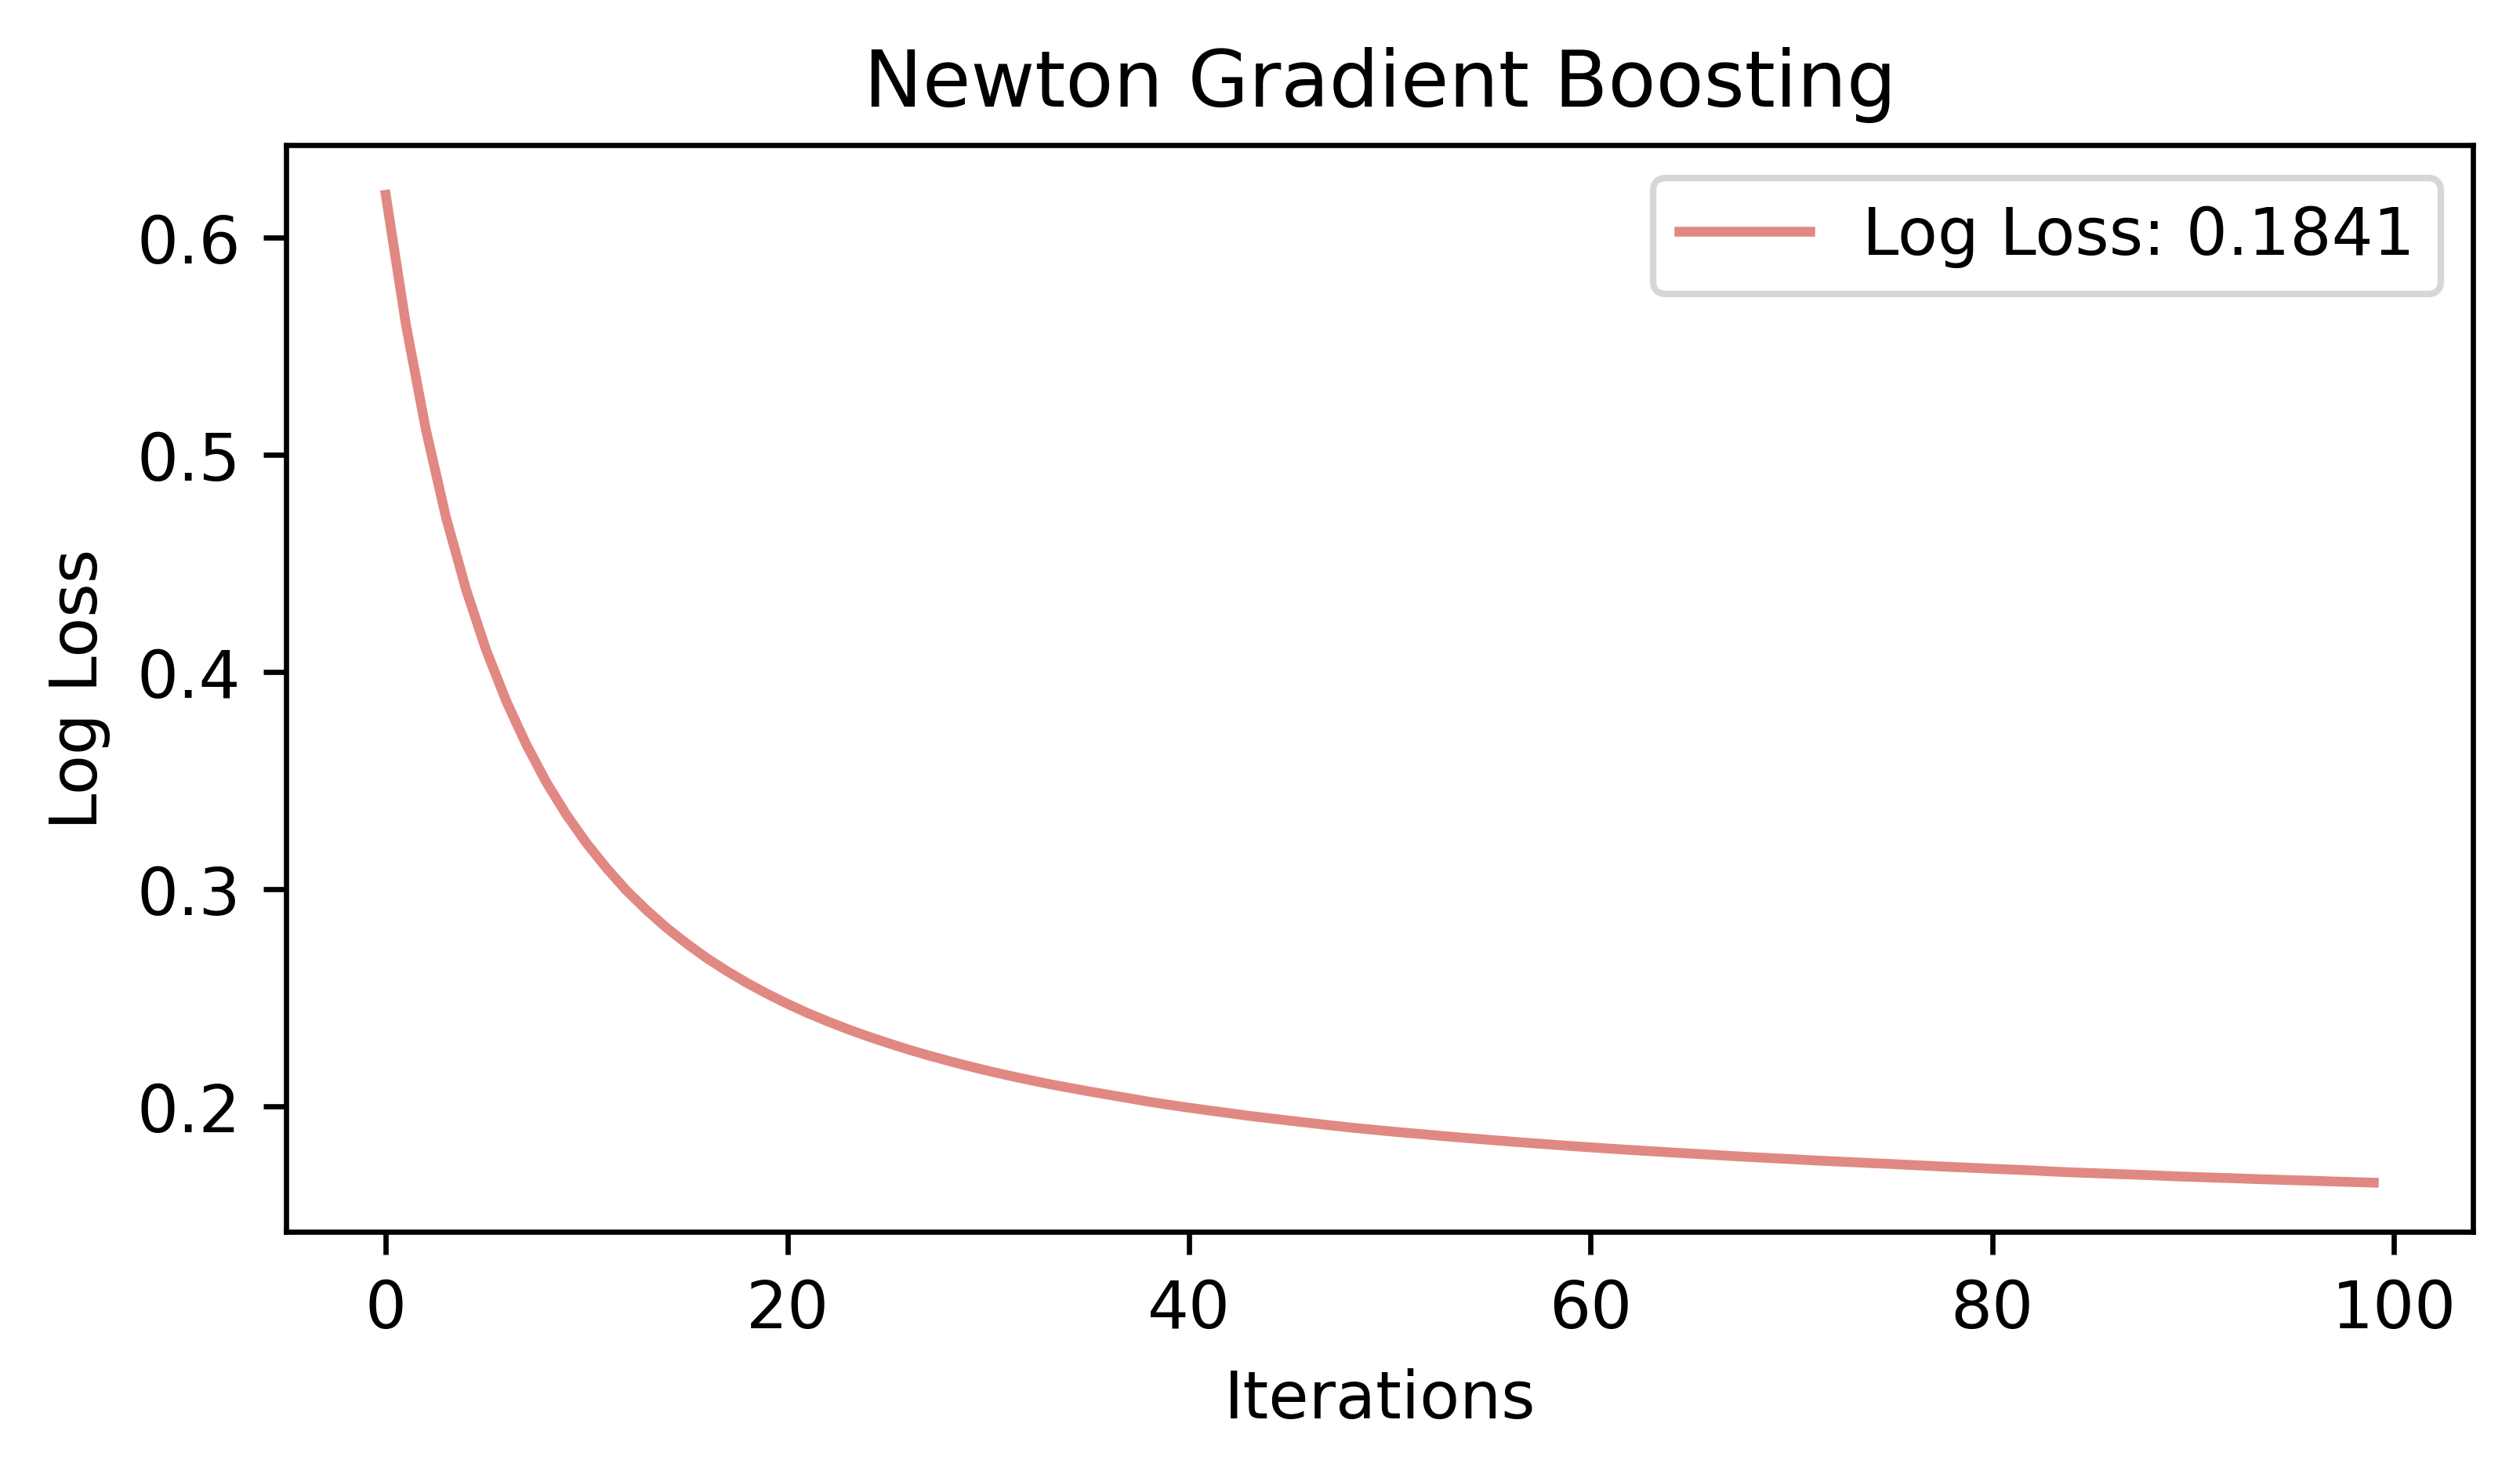

In [5]:
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

gbdt_newton = GradientBoostingClassifier(n_iter=100, learning_rate=.4, base_learner='tree', method='Newton')
gbdt_newton.fit(X.loc[ix_train], y.loc[ix_train])

gini_train = roc_auc_score(y.loc[ix_train], gbdt_newton.predict_proba(X.loc[ix_train])[:, 1]) * 2 - 1
gini_test = roc_auc_score(y.loc[ix_test], gbdt_newton.predict_proba(X.loc[ix_test])[:, 1]) * 2 - 1

print(f"Gini train: {gini_train:.2%}")
print(f"Gini test: {gini_test:.2%}")

log_loss_score = log_loss(y.loc[ix_test], gbdt_newton.predict_proba(X.loc[ix_test])[:, 1])

print(np.array(gbdt_newton.loss_dict).min())

plt.figure(figsize=(6, 3), dpi=600)
plt.title("Newton Gradient Boosting")
plt.plot(gbdt_newton.loss_dict, color='#e18882', label=f"Log Loss: {log_loss_score:.4f}")
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()